In [25]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from deepxde.backend import torch
import torch
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

In [26]:
ub = 200
rb = 20

In [27]:
def func(t, r):
    x, y = r
    dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
    dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
    return dx_t, dy_t


def gen_truedata():
    
    t = np.linspace(0, 1, 100)
    sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true


def ode_system(x, y):
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    
    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]

In [28]:
geom = dde.geometry.TimeDomain(0, 1.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test=3000)

layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

In [29]:
# Backend tensorflow.compat.v1 or tensorflow
# def input_transform(t):
#     return tf.concat(
#         (
#             t,
#             tf.sin(t),
#             tf.sin(2 * t),
#             tf.sin(3 * t),
#             tf.sin(4 * t),
#             tf.sin(5 * t),
#             tf.sin(6 * t),
#         ),
#         axis=1,
#     )
# Backend pytorch
def input_transform(t):
    return torch.cat(
        [
            torch.sin(t),
            # torch.sin(2 * t),
            # torch.sin(3 * t),
            # torch.sin(4 * t),
            # torch.sin(5 * t),
            # torch.sin(6 * t)
        ],
        dim=1,
    )

# hard constraints: x(0) = 100, y(0) = 15
# Backend tensorflow.compat.v1 or tensorflow
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return tf.concat([y1 * tf.tanh(t) + 100 / ub, y2 * tf.tanh(t) + 15 / ub], axis=1)
# Backend pytorch
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    return torch.cat([y1 * torch.tanh(t) + 100 / ub, y2 * torch.tanh(t) + 15 / ub], dim=1)

In [30]:
net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

In [31]:
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=5000)

Compiling model...
'compile' took 0.000393 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.61e+02, 6.16e-01]    [2.62e+02, 6.14e-01]    []  
1000      [2.43e+00, 5.79e-01]    [2.32e+00, 5.68e-01]    []  
2000      [1.93e+00, 6.03e-01]    [1.84e+00, 5.92e-01]    []  
3000      [1.56e+00, 5.66e-01]    [1.48e+00, 5.52e-01]    []  
4000      [1.32e+00, 5.23e-01]    [1.25e+00, 5.09e-01]    []  
5000      [1.08e+00, 4.65e-01]    [1.02e+00, 4.51e-01]    []  

Best model at step 5000:
  train loss: 1.54e+00
  test loss: 1.47e+00
  test metric: []

'train' took 80.856586 s



Saving loss history to /home/abyss/github-repo/DiffEq-DL/loss.dat ...
Saving training data to /home/abyss/github-repo/DiffEq-DL/train.dat ...
Saving test data to /home/abyss/github-repo/DiffEq-DL/test.dat ...


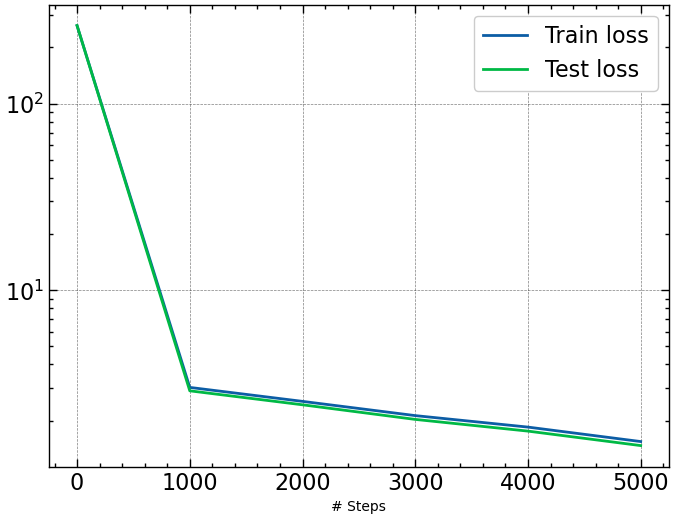

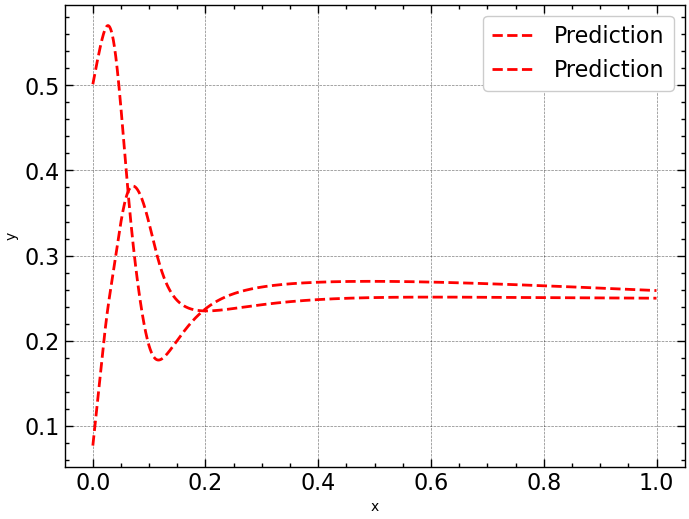

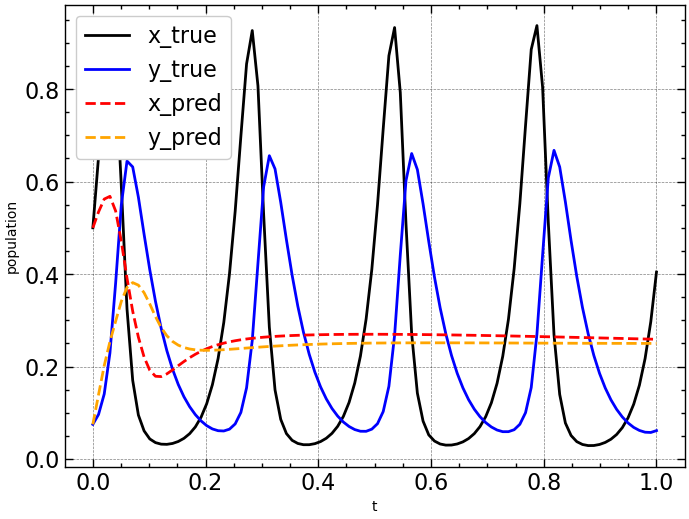

In [32]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()

In [ ]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Saving loss history to /home/abyss/github-repo/DiffEq-DL/loss.dat ...
Saving training data to /home/abyss/github-repo/DiffEq-DL/train.dat ...
Saving test data to /home/abyss/github-repo/DiffEq-DL/test.dat ...


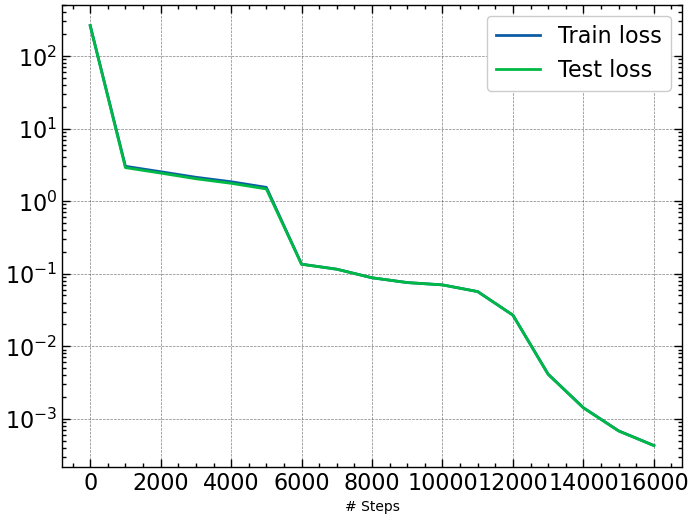

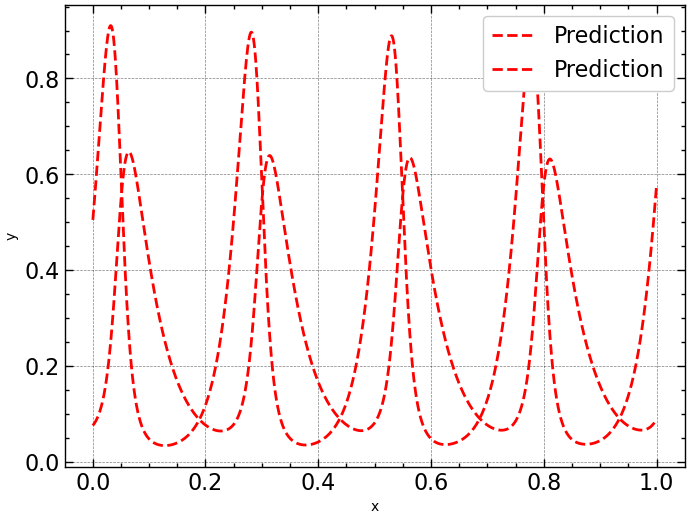

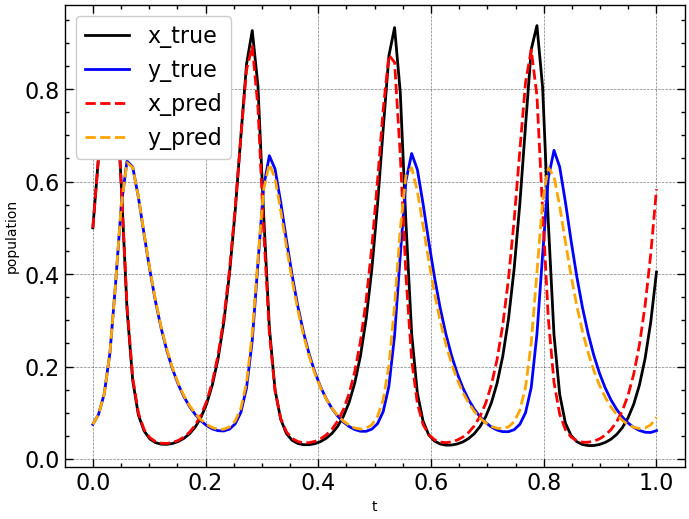

In [34]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()